In [1]:
import matplotlib.pyplot as plt
#%matplotlib widget
from ipywidgets import *
import numpy as np
import sys

In [2]:
import taurex.log
taurex.log.disableLogging()
from taurex.cache import OpacityCache,CIACache


In [3]:
path_to_data = '/home/menegattig/Downloads'
OpacityCache().clear_cache()
OpacityCache().set_opacity_path(f"{path_to_data}/atmosphere/xsecs")
CIACache().set_cia_path(f"{path_to_data}/atmosphere/cia/hitran")

# Creating planet to retrieve

In [4]:
from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=1415.0)

from taurex.planet import Planet
planet = Planet(planet_radius=1.2,planet_mass=0.8)

from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=6230.0,radius=1.28)

from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)

from taurex.chemistry import ConstantGas
H2O=10**np.random.uniform(-2,-8)
CH4=10**np.random.uniform(-2,-8)
CO2=10**np.random.uniform(-2,-8)
CO=10**np.random.uniform(-2,-8)

chemistry.addGas(ConstantGas('H2O',mix_ratio=H2O))
chemistry.addGas(ConstantGas('CH4',mix_ratio=CH4))
chemistry.addGas(ConstantGas('CO2',mix_ratio=CO2))
chemistry.addGas(ConstantGas('CO',mix_ratio=CO))

In [5]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

from taurex.contributions import CIAContribution
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

tm.build()
res = tm.model()

from taurex.binning import FluxBinner,SimpleBinner
#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))


In [6]:
# we take the data of our simulated spectrum taking as error the square root of (Rp/Rs)^2 (Poisson error)
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum(f'WASP_62b_synthetic_spectrum.dat')

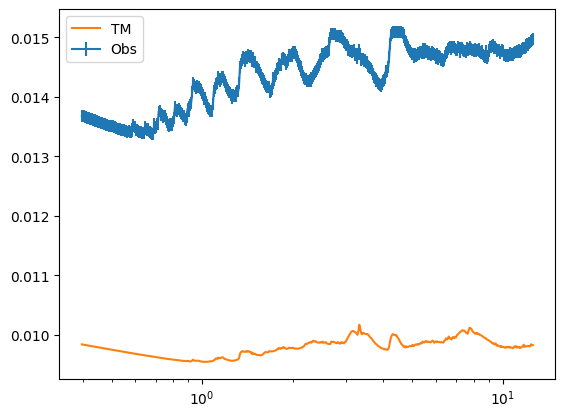

In [7]:
# now we make a binning and plot the spectrum:
obin = obs.create_binner()
plt.figure()
plt.errorbar(obs.wavelengthGrid,obs.spectrum, obs.errorBar,label='Obs')
plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
plt.xscale('log')
plt.legend()
plt.show()

In [8]:
from taurex.optimizer.nestle import NestleOptimizer
opt = NestleOptimizer(num_live_points=50)

opt.set_model(tm)
opt.set_observed(obs)

In [9]:
opt.enable_fit('planet_radius')
opt.enable_fit('T_irr')
opt.enable_fit('H2O')
opt.enable_fit('CH4')
opt.enable_fit('CO2')
opt.enable_fit('CO')
opt.set_boundary('T_irr',[1000,2000])
opt.set_boundary('planet_radius',[0.8,2.1])
opt.set_boundary('H2O', [1e-8,1e-2])
opt.set_boundary('CH4', [1e-8,1e-2])
opt.set_boundary('CO', [1e-8,1e-2])
opt.set_boundary('CO2', [1e-8,1e-2])

In [10]:
solution = opt.fit()
taurex.log.disableLogging()

it=  1020 logz=4096.54385091777niter: 1021
ncall: 3581
nsamples: 1071
logz: 4096.790 +/-  0.584
h: 17.063


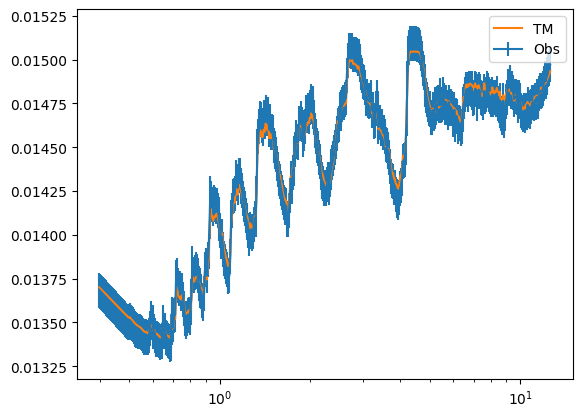

In [11]:
for solution,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
    plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
    plt.xscale('log')
    plt.legend()
    plt.show()

In [13]:
res = opt.generate_solution()

In [ ]:
import pandas as pd
import corner

In [37]:
fit_params = res['solution0']['fit_params']

traces = np.array([fit_params[key]['trace'] for key in fit_params.keys()])


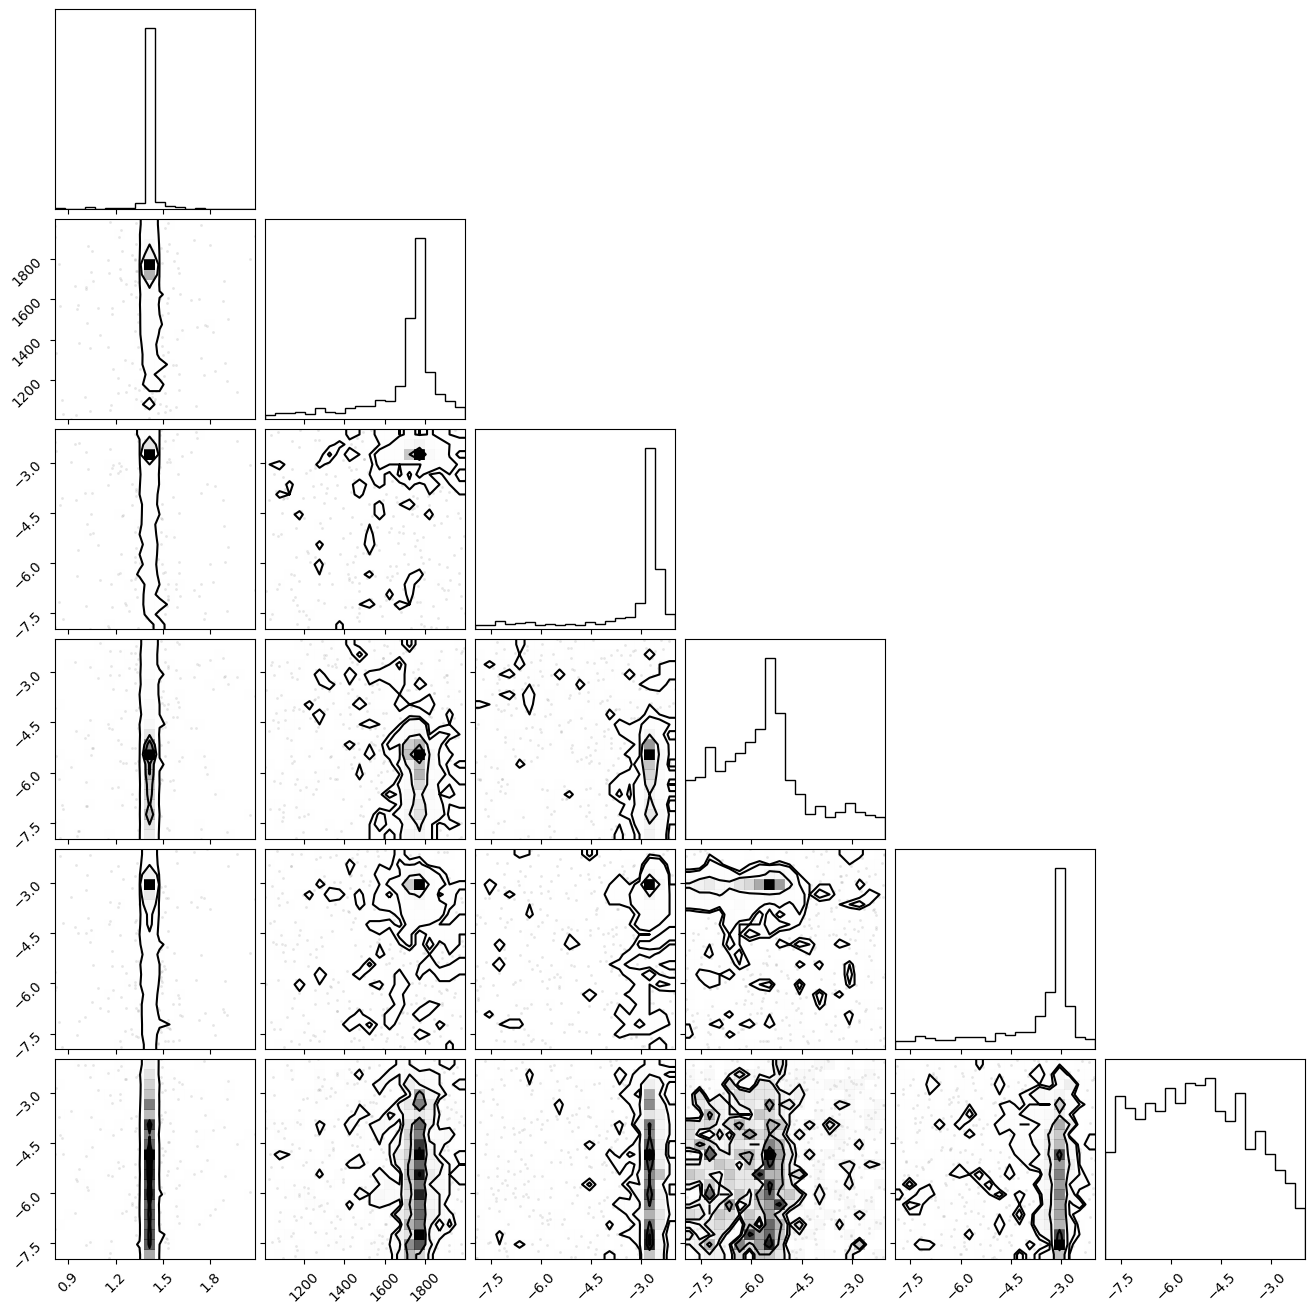

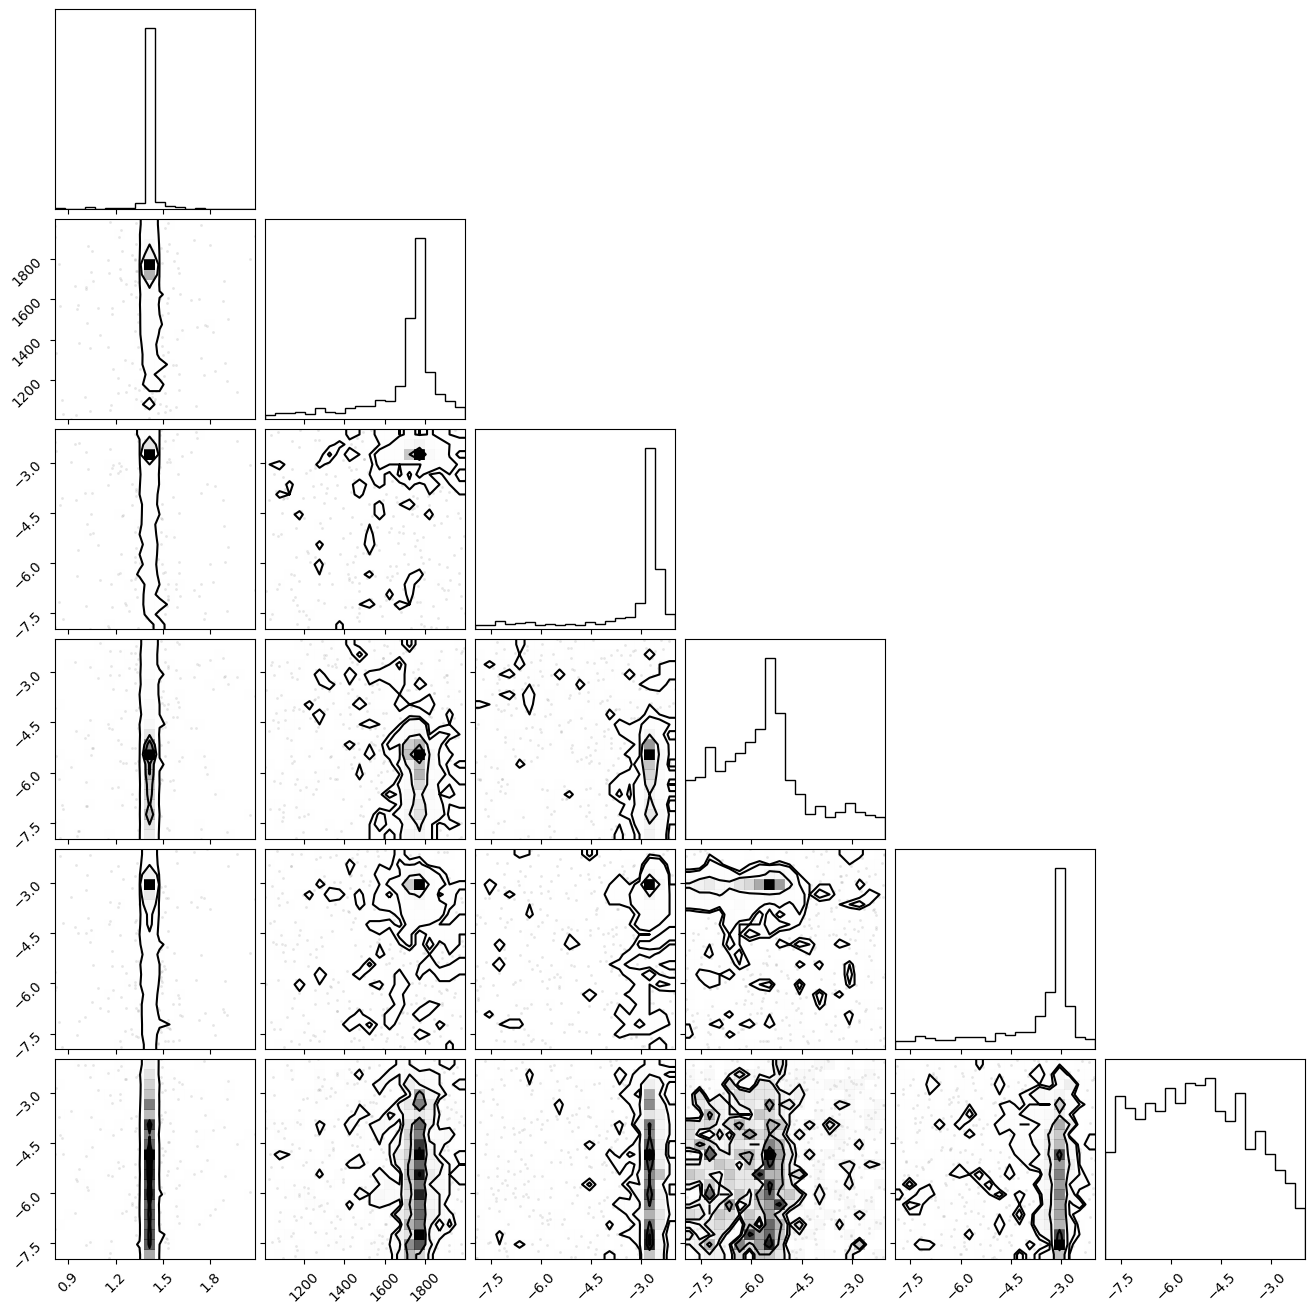

In [40]:
corner.corner(np.transpose(traces))